In [1]:
%load_ext autoreload
%autoreload 2


# import mkl
# mkl.set_num_threads(1)

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
%run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
%run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
icecube (full) astro events: 3190.7342562161975
Below -4.59 deg, A_eff is set to 0
starting aeff rotations
Saving up-going effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
Saving full effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!
Flux will be saved to: /home/hpc/capn/capn102h/repos/Plenum/resources/MCEq_daemonflux.pckl
args: Namespace(renew_calc=False, kde=False)
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Saving background flux to:  /home/hpc/capn/capn102h/repos

# Imports

In [ ]:
import pickle
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor

from matplotlib.colors import LogNorm
from scipy.interpolate import InterpolatedUnivariateSpline

import settings as st
from settings import plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from glob import glob
from astropy.constants import h

from resolution import get_baseline_eres, energy_smearing

# Settings

In [4]:
# coordinates
# PKS 1502+106
pks1502 = SkyCoord(
    ra="15:04:24.98", dec="+10:29:39.2", frame="icrs", unit=(u.hourangle, u.deg)
)
# TXS: defined in settings
print(st.txs0506)

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (77.3593, 5.7014)>


In [ ]:
E = 1 * u.erg
nu = 1 * u.Hz
Enu = nu * h

# Energy unit conversion
erg_to_GeV = E.to(u.GeV).value
nu_to_GeV = Enu.to(u.GeV).value
nu_to_erg = Enu.to(u.erg).value

print(erg_to_GeV, nu_to_GeV, nu_to_erg)

624.1509074460764 4.135667696923859e-24 6.62607015e-27


# energy resolution

In [ ]:
energy_res_mephistograms = get_baseline_eres(renew_calc=False)
# need to set to True for initial calculation,
# OR set to false and download pre-computed file

file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl


In [ ]:
energy_res_mephistograms.keys() # South: [-90, -10], Horizon: [-10, 10], North: [10, 90]

dict_keys(['dec--50.0', 'dec-0.0', 'dec-50.0'])

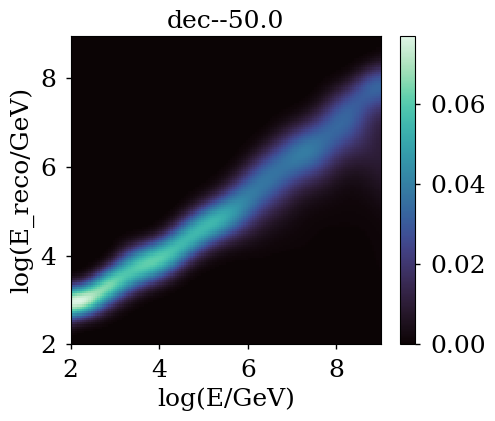

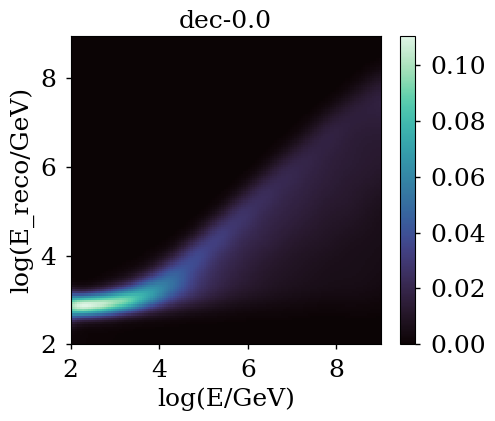

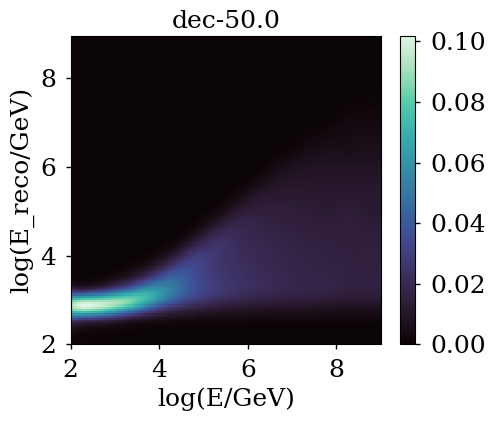

In [8]:
# plot
for k, eres in energy_res_mephistograms.items():
    eres.plot()
    plt.gca().set_title(k)


## Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [9]:
with open(join(st.LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)

print(aeff_2d_full.keys())

dict_keys(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT', 'HUNT', 'NEON', 'Gen-2'])


## Atmospheric background
We need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is why there are multiple BG fluxes, one for each detector.

In [10]:
with open(join(st.LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d_full["IceCube"], verbose=True))

Elementary arithmetic possible.
True


In [11]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1, # not needed here
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = 1 #  set to desired angular distance for background integration area
bg_config["grid_2d"] = 1 # not needed here

GAMMA_TXS = 2. # best fit from [? 2022 NGC paper, I think]
PHI_TXS = 2.7E-20 # best fit from [?]
E0_TXS = 1E5 # 100 TeV

# Models


## setup

In [12]:
base_dct = {"src_name": 0, "model_name": 0, "state": 0, "bf_or_band": 0, "N_nu(IC)": 0, "model_spline": 0, "dec/rad": 0, "livetime/s": 0}
all_models = []

In [42]:
flare_files = glob(join(st.LOCALPATH, "neutrino_models/txs*neutrino*.csv"))


In [43]:
flare_files

['/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/txs_rkp_neutrino_bestfit.csv',
 '/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/txs_neutrino_bestfit.csv']

In [44]:
# for the legend because I am lazy
style = {
    "proton-synchrotron": dict(label="proton-synchrotron", color="darkred", ls="-"),
    "ext_field_a": dict(label="ext_field_a", color="tab:blue", ls=":"),
    "lepto-hadronic": dict(label="lepto-hadronic", color="tab:orange", ls="--"),
}

Text(0.5, 0, 'E/GeV')

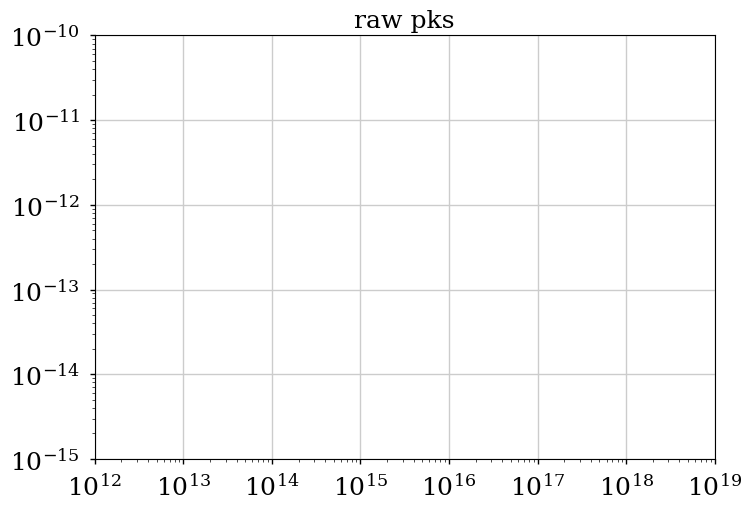

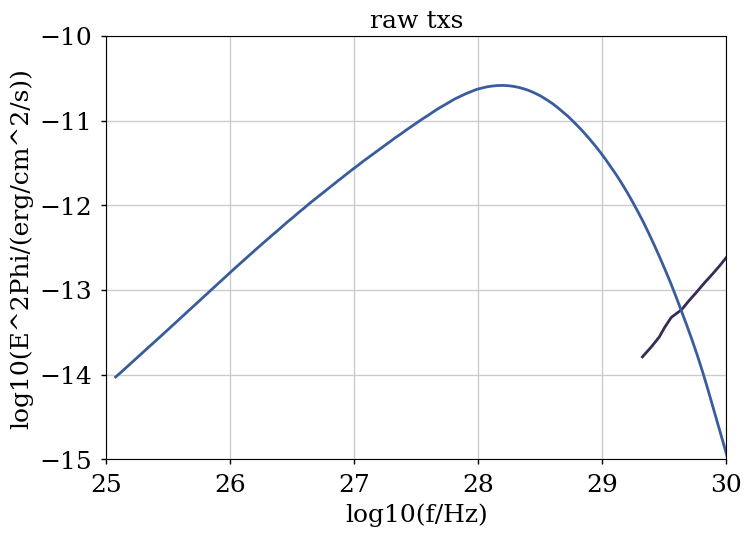

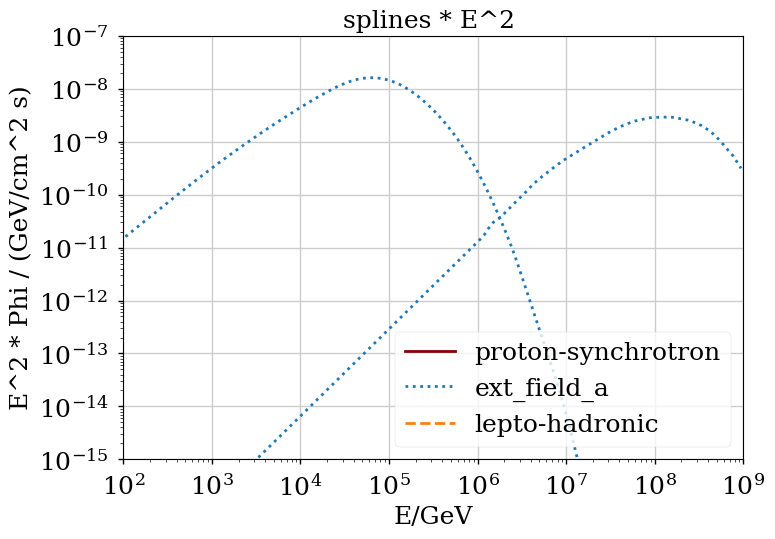

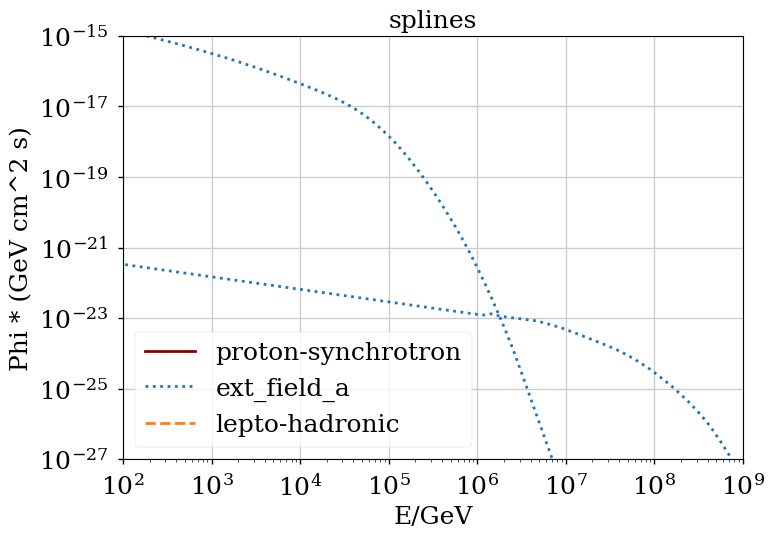

In [45]:
tmp = []
plt.figure(1)
plt.title("raw pks")
plt.loglog()
plt.ylim(1e-15, 1e-10)
plt.xlim(1e12, 1e19)

plt.figure(3)
plt.title("splines * E^2 ")

plt.figure(4)
plt.title("splines")

for f in flare_files:
    # print(f)
    if "PSYN" in f:
        model = "proton-synchrotron"
    elif "txs" in f:
        model = "ext_field_a"
    else:
        model = "lepto-hadronic"

    if "pks_quiescent_neutrinos_bandmin" in f:
        # all zeros
        continue
    mapping = (
        {0: "E/eV", 1: "nuF/(erg/cm^2/s)"}
        if "pks" in f
        else {0: "log10(f/Hz)", 1: "log10(E^2Phi/(erg/cm^2/s))"}
    )
    dat = pd.read_csv(f, header=None).T.rename(columns=mapping)
    labels = f.split("/")[-1].split(".")[0].split("_")

    if "pks" in f:
        mask = dat["nuF/(erg/cm^2/s)"] > 0  # 1e-30
        x = np.log10(dat["E/eV"].loc[mask] / 1e9)  # eV -> GeV
        y = (
            np.log10(dat["nuF/(erg/cm^2/s)"].loc[mask] * erg_to_GeV) - 2 * x
        )  #  nu F_nu -> dN/dt dE dA
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)
        plt.figure(1)
        ax = sns.lineplot(
            data=dat,
            x="E/eV",
            y="nuF/(erg/cm^2/s)",
            color=style[model]["color"],
            ls=style[model]["ls"],
        )

    elif "txs" in f:
        mask = dat["log10(E^2Phi/(erg/cm^2/s))"] > -100  # -30
        x = dat["log10(f/Hz)"].loc[mask] + np.log10(nu_to_GeV)  # nu -> GeV
        y = (
            dat["log10(E^2Phi/(erg/cm^2/s))"].loc[mask] + np.log10(erg_to_GeV) - 2 * x
        )  #  E² Phi [erg] -> Phi [GeV]
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)

        plt.figure(2)
        plt.title("raw txs")
        ax = sns.lineplot(data=dat, x="log10(f/Hz)", y="log10(E^2Phi/(erg/cm^2/s))")
        ax.set_ylim(-15, -10)
        ax.set_xlim(25, 30)

    else:
        print("???")

    plt.figure(3)
    plt.plot(
        10**st.logE_mids,
        10 ** (model_spline(st.logE_mids) + 2 * st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )
    plt.figure(4)
    plt.plot(
        10**st.logE_mids,
        10 ** model_spline(st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )

    tmp.append(
        {
            "src_name": labels[0],
            "model_name": model,
            "state": labels[-3],
            "bf_or_band": labels[-1],
            "model_spline": model_spline,
            "N_nu(IC)": 0,
            "dec/rad": 0,
            "livetime/s": 0,
        }
    )

plt.figure(3)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-15, 1e-7)
plt.ylabel("E^2 * Phi / (GeV/cm^2 s)")
plt.xlabel("E/GeV")

plt.figure(4)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-27, 1e-15)
plt.ylabel("Phi * (GeV cm^2 s)")
plt.xlabel("E/GeV")

In [46]:
flare_models_x = pd.DataFrame(tmp)
flare_models_x.loc[flare_models_x.src_name=="pks", "dec/rad"] = pks1502.dec.rad
flare_models_x.loc[flare_models_x.src_name=="pks", "livetime/s"] = 365 * 24 * 3600 * 3.7 
# "the flux has now been integrated over the total duration of each activity state 
# (3.8 years quiescent, 3.7 years of hard flares, and 3.5 years of soft flares, cf. Tab. 1). 
# from arXiv:2009.04026
flare_models_x.loc[flare_models_x.src_name=="txs", "dec/rad"] = st.txs0506.dec.rad
flare_models_x.loc[flare_models_x.src_name=="txs", "livetime/s"] = 158 * 24 * 3600

#flare_models_x
for _, series in flare_models_x.loc[flare_models_x.bf_or_band=="bestfit"].iterrows(): # 
    # if "proton" in series.model_name: continue
    print(series)
    aeff_factor_signal = calc_aeff_factor(
            aeff_2d_full["IceCube"],
            dec=series["dec/rad"],
            livetime=series["livetime/s"],
            **src_config,
        )
    # calculate expected number of signal events and add to data
    nev = aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    print(np.sum(nev))
    flare_models_x.loc[_, "N_nu(IC)"] = np.sum(nev)
    print("")

src_name                                                      txs
model_name                                            ext_field_a
state                                                         rkp
bf_or_band                                                bestfit
model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
N_nu(IC)                                                        0
dec/rad                                                  0.099508
livetime/s                                               13651200
Name: 0, dtype: object
0.04688442473852502

src_name                                                      txs
model_name                                            ext_field_a
state                                                         txs
bf_or_band                                                bestfit
model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
N_nu(IC)                                                        0
dec/rad                         

In [16]:
selected_models = {
    "PKS 1502+106 lepto-had. (Rodrigues et al.)": {
        "model": flare_models_x.loc[
            (flare_models_x.bf_or_band == "bestfit")
            & (flare_models_x.src_name == "pks")
            & (flare_models_x.state == "hardflare")
            & (flare_models_x.model_name == "lepto-hadronic")
        ].iloc[0],
        "start_scaler": 6,
        "coords": pks1502,
    },
    "TXS 0506+056 (Rodrigues et al.)": {
        "model": flare_models_x.loc[
            (flare_models_x.bf_or_band == "bestfit")
            & (flare_models_x.src_name == "txs")
        ].iloc[0],
        "start_scaler": 17,
        "coords": st.txs0506,
    },
}

In [47]:
flare_models_x

,src_name,model_name,state,bf_or_band,model_spline,N_nu(IC),dec/rad,livetime/s
0,txs,ext_field_a,rkp,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.046884,0.099508,13651200
1,txs,ext_field_a,txs,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.866360,0.099508,13651200


In [48]:
selected_models = {
    "TXS 0506+056 (Rodrigues et al. 2024)": {
        "model": flare_models_x.iloc[0],
        "start_scaler": 1,
        "coords": st.txs0506,
    },
    "TXS 0506+056 (Rodrigues et al. 2019)": {
        "model": flare_models_x.iloc[1],
        "start_scaler": 1,
        "coords": st.txs0506,
    },
}

## Event distribution in reco energy

(2.0, 9.0)

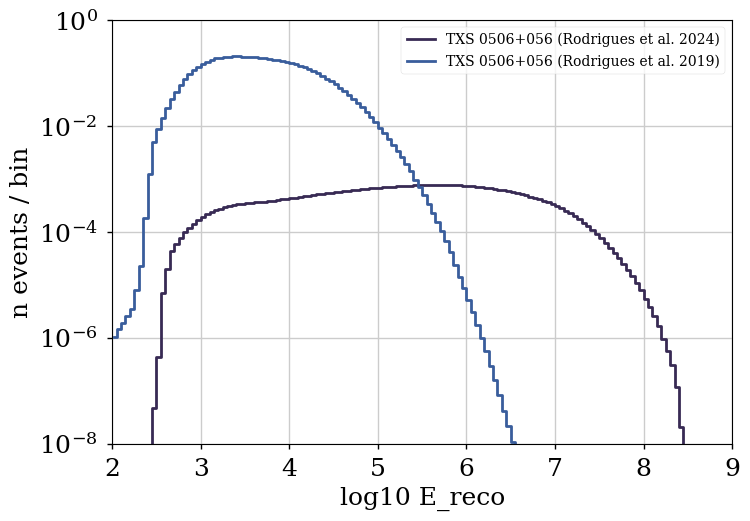

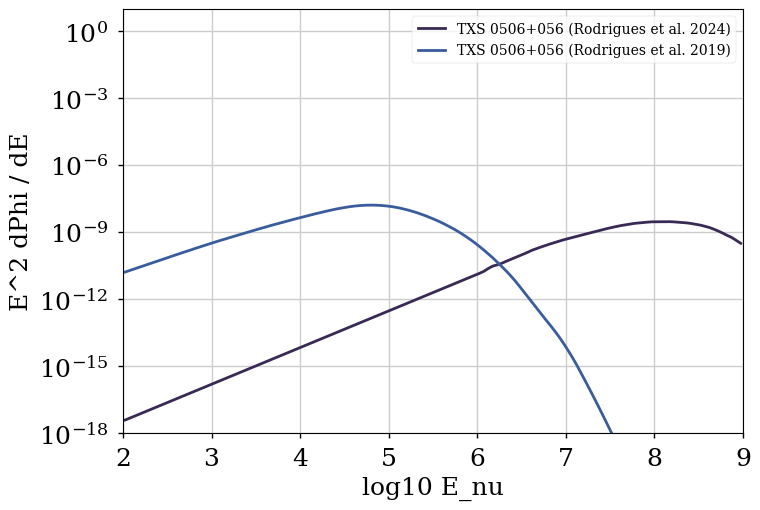

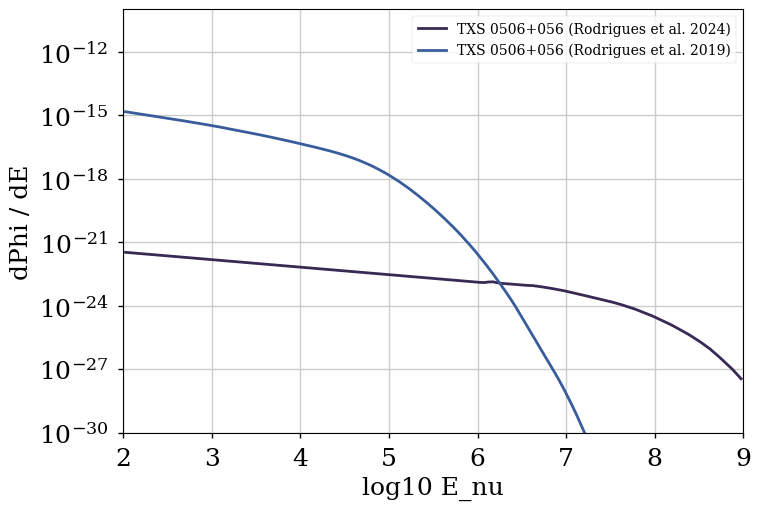

In [49]:
for model_key, dct in selected_models.items():
    series = dct["model"]
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"],
        dec=series["dec/rad"],
        livetime=series["livetime/s"] if series.state != "grb" else 1,
        **src_config,
    )

    nev = energy_smearing(
        energy_res_mephistograms["dec-0.0"], # for simplicity, choose E_res of horizon
        aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    )
    plt.figure(1)
    plt.plot(st.logE_reco_mids, nev, ds="steps-mid", label=model_key)
    plt.figure(2)
    plt.plot(
        st.logE_mids,
        10 ** (series["model_spline"](st.logE_mids) + 2 * st.logE_mids),
        label=model_key,
    )
    plt.figure(3)
    plt.plot(
        st.logE_mids, 10 ** (series["model_spline"](st.logE_mids)), label=model_key
    )

plt.figure(1)
plt.yscale("log")
plt.xlim(2, 9)
plt.ylabel("n events / bin")
plt.xlabel("log10 E_reco")
plt.legend(fontsize="medium")
plt.ylim(1e-8, 1)

plt.figure(2)
plt.yscale("log")
plt.ylabel("E^2 dPhi / dE")
plt.xlabel("log10 E_nu")
plt.legend(fontsize="medium")
plt.ylim(1e-18, 10)
plt.xlim(2, 9)

plt.figure(3)
plt.yscale("log")
plt.ylabel("dPhi / dE")
plt.xlabel("log10 E_nu")
plt.legend(fontsize="medium")
plt.ylim(1e-30, 1E-10)
plt.xlim(2, 9)

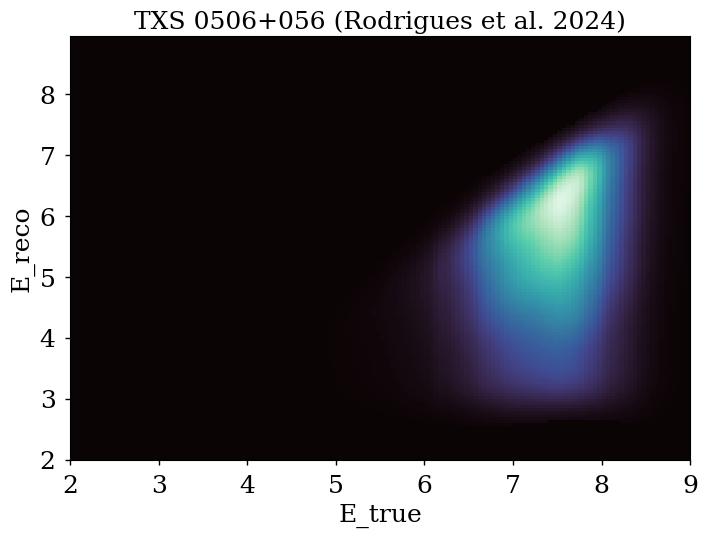

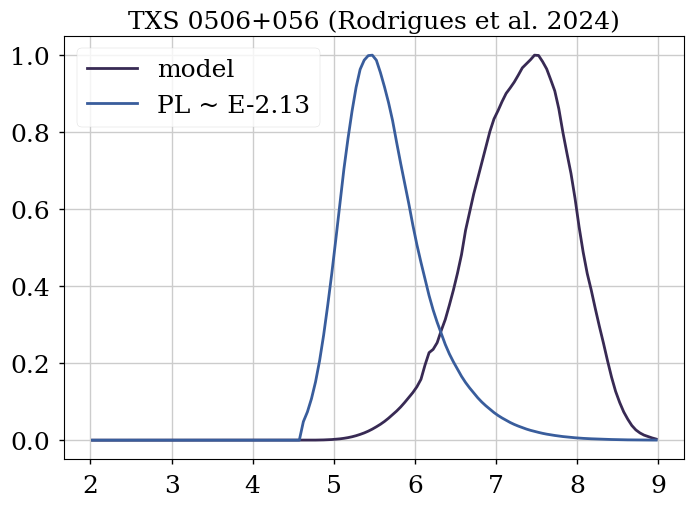

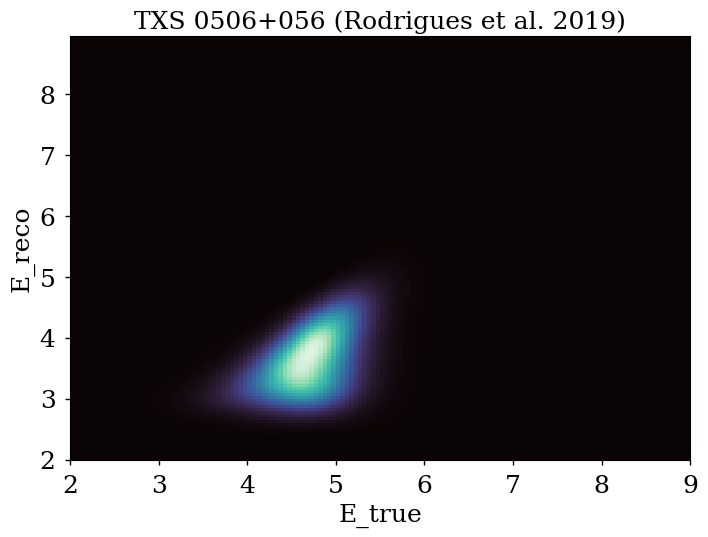

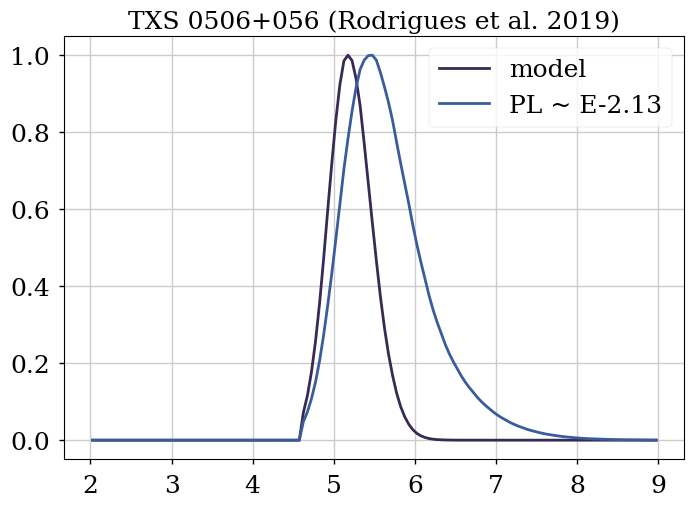

In [53]:
for model_key, dct in selected_models.items():
    series = dct["model"]
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"],
        dec=series["dec/rad"],
        livetime=series["livetime/s"] if series.state != "grb" else 1,
        **src_config,
    )
    # for simplicity, choose E_res of horizon

    nev_2d = (
        aeff_factor_signal * 10 ** (series["model_spline"](st.logE_mids))
    ) * energy_res_mephistograms["dec-0.0"].T()
    plt.figure()
    plt.pcolormesh(st.logE_bins, st.logE_reco_bins, nev_2d)  # , norm=LogNorm())

    plt.xlabel("E_true")
    plt.ylabel("E_reco")
    plt.title(model_key)

    plt.figure()
    plt.title(model_key)
    mask = st.logE_reco_mids >= np.log10(52e3)  # 52 TeV
    plt.plot(st.logE_mids, nev_2d[mask][0] / np.max(nev_2d[mask][0]), label="model")

    nev_2d = (
        aeff_factor_signal * (10**st.logE_mids) ** -2.13
    ) * energy_res_mephistograms["dec-0.0"].T()
    plt.plot(st.logE_mids, nev_2d[mask][0] / np.max(nev_2d[mask][0]), label="PL ~ E-2.13")
    plt.legend()

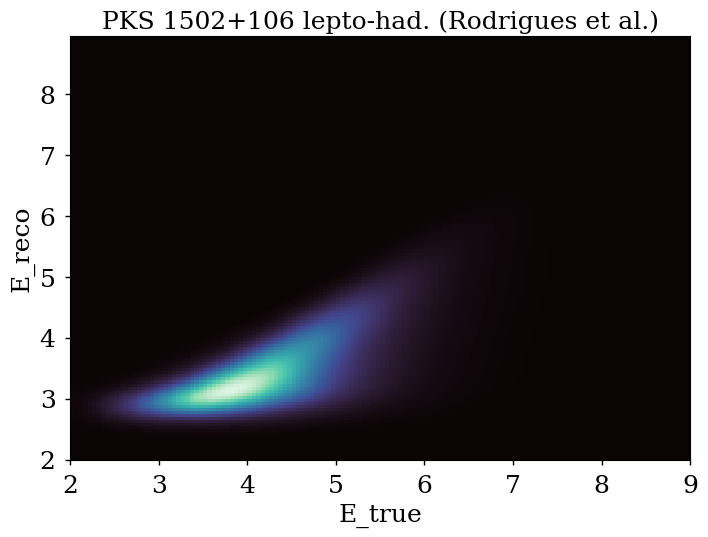

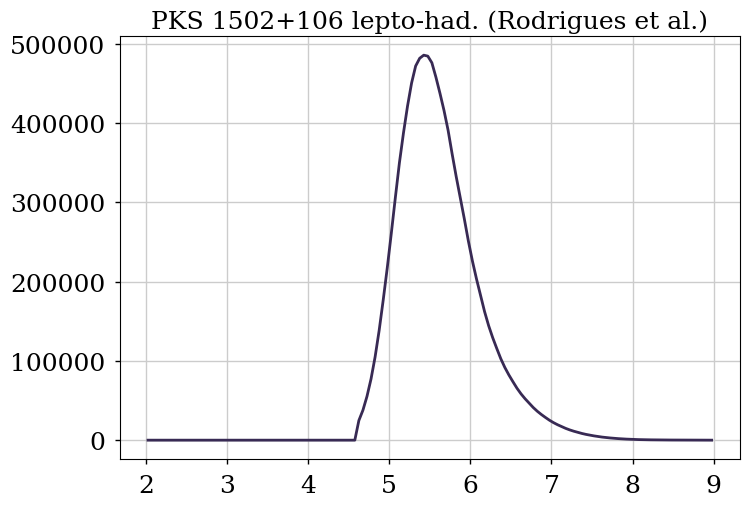

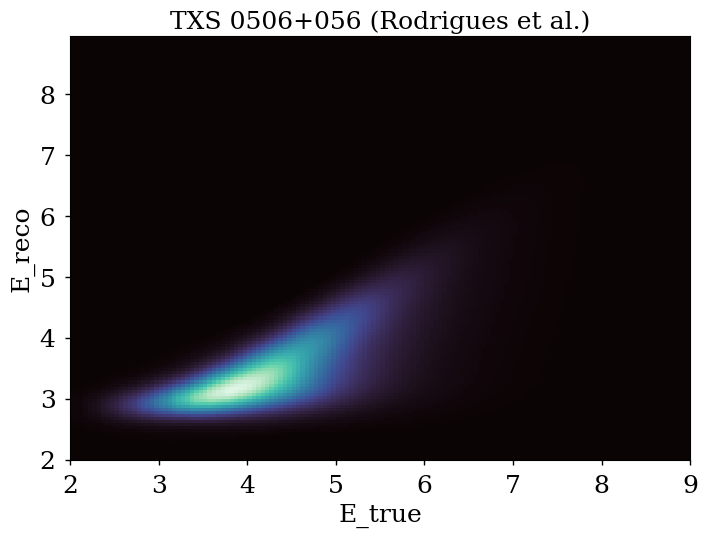

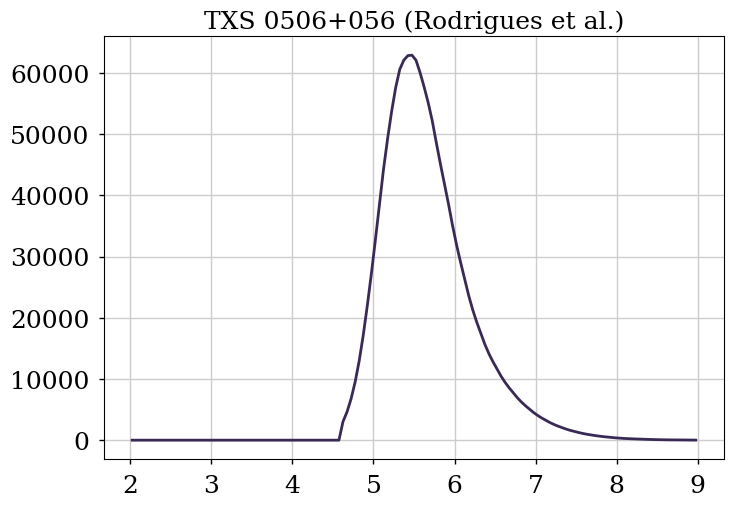

In [21]:
for model_key, dct in selected_models.items():
    series = dct["model"]
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"],
        dec=series["dec/rad"],
        livetime=series["livetime/s"] if series.state != "grb" else 1,
        **src_config,
    )
    # for simplicity, choose E_res of horizon
    nev_2d = (aeff_factor_signal * (10**st.logE_mids) ** -2.13) * energy_res_mephistograms["dec-0.0"].T()
    plt.figure()
    plt.pcolormesh(st.logE_bins, st.logE_reco_bins, nev_2d)  # , norm=LogNorm())

    plt.xlabel("E_true")
    plt.ylabel("E_reco")
    plt.title(model_key)

    plt.figure()
    plt.title(model_key)
    mask = st.logE_reco_mids >= np.log10(52E3)
    plt.plot(st.logE_mids, nev_2d[mask][0])

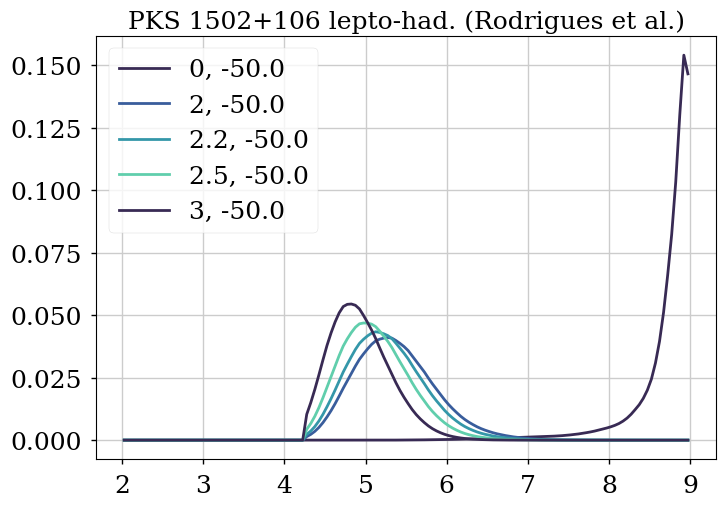

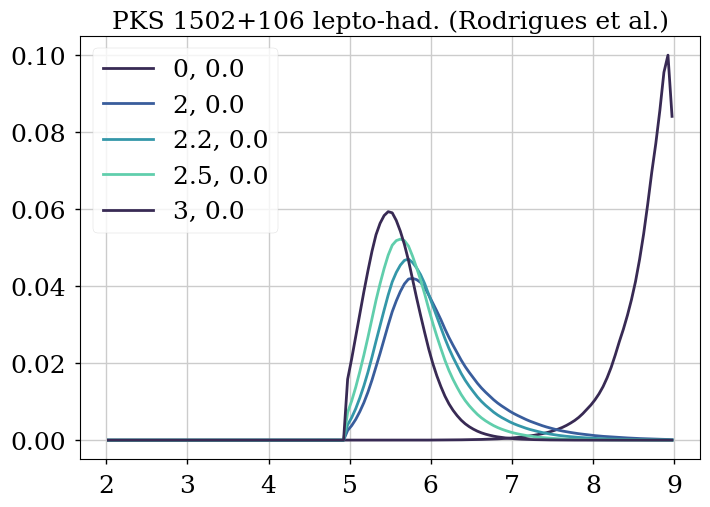

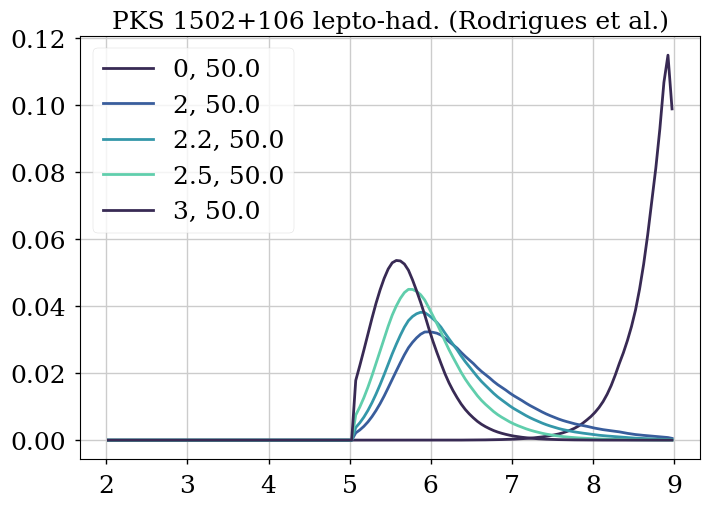

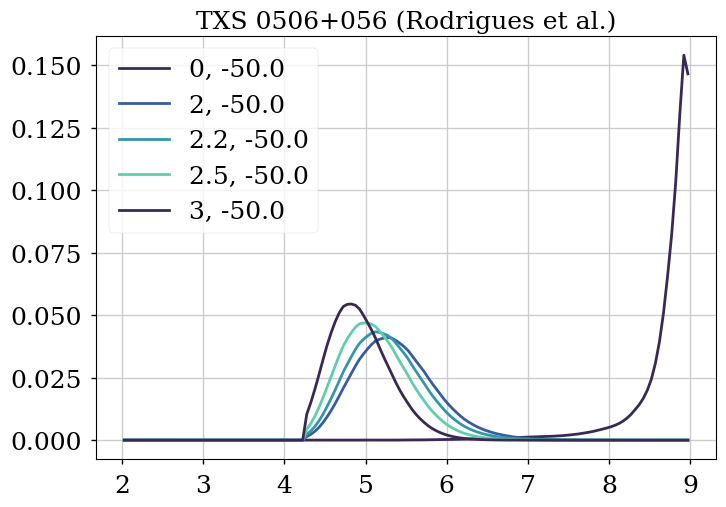

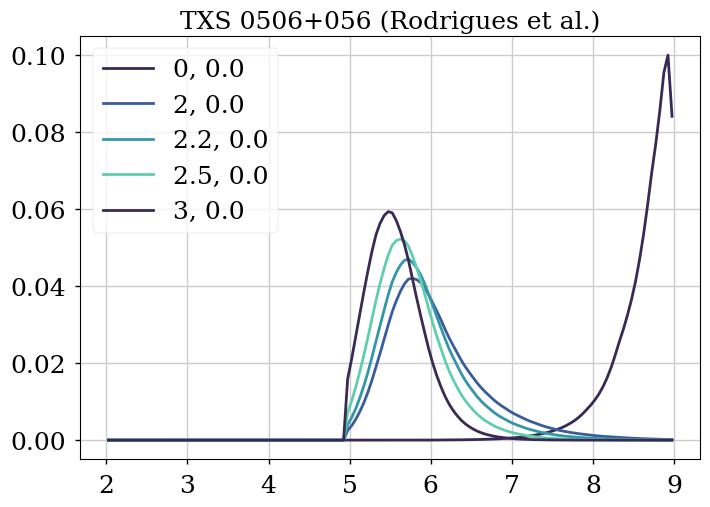

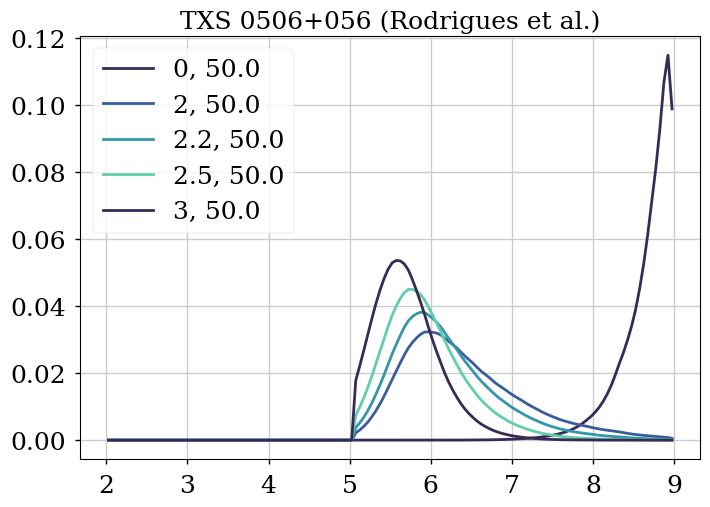

In [19]:
for model_key, dct in selected_models.items():
    series = dct["model"]
    dec = [-50.0, 0.0, 50.0]
    for d in dec:
        plt.figure()
        plt.title(model_key)
        aeff_factor_signal = calc_aeff_factor(
            aeff_2d_full["KM3NeT"],  # KM3NeT Aeff
            dec=np.deg2rad(d),
            livetime=series["livetime/s"] if series.state != "grb" else 1,
            **src_config,
        )
        ### PUT IN DIFFERENT ENERGY RES PER DEC
        for gamma in [0, 2, 2.2, 2.5, 3]:
            nev_2d = (
                aeff_factor_signal * (10**st.logE_mids) ** -gamma
            ) * energy_res_mephistograms[f"dec-{d}"].T()
            mask = st.logE_reco_mids >= 5  # 100 TeV
            plt.plot(
                st.logE_mids,
                nev_2d[mask][0] / np.sum(nev_2d[mask][0]),
                label=f"{gamma}, {d}",
            )
        plt.legend()